# Feature Engineering and Dataset Balancing for Emotion Recognition

This notebook implements feature engineering and dataset balancing techniques to improve the emotion recognition model performance by addressing class imbalance issues.

## Problem Statement
The EmoSet dataset has significant class imbalance:
- **happy**: 25.24% (overrepresented)
- **surprise**: 11.29% (underrepresented)
- Other emotions range from 14-17%

## Solution Approach
1. Analyze current dataset distribution
2. Implement dataset balancing techniques
3. Create balanced train/validation/test splits
4. Save processed datasets for model training

In [11]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.utils import resample
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Feature Engineering Environment Setup Complete")

Feature Engineering Environment Setup Complete


In [12]:
# Define project paths
PROJECT_ROOT = Path('../')
CSV_TRAIN = PROJECT_ROOT / 'data/processed/EmoSet_splits/train.csv'
CSV_VAL = PROJECT_ROOT / 'data/processed/EmoSet_splits/val.csv'
CSV_TEST = PROJECT_ROOT / 'data/processed/EmoSet_splits/test.csv'
LABEL_MAP_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/label_map.json'
STATS_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/stats.json'
DATA_DIR = PROJECT_ROOT / 'data/raw/EmoSet'

# Output paths for balanced datasets
BALANCED_TRAIN_CSV = PROJECT_ROOT / 'data/processed/EmoSet_splits/train_balanced.csv'
BALANCED_VAL_CSV = PROJECT_ROOT / 'data/processed/EmoSet_splits/val_balanced.csv'
BALANCED_TEST_CSV = PROJECT_ROOT / 'data/processed/EmoSet_splits/test_balanced.csv'
BALANCED_STATS_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/stats_balanced.json'

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print("\nInput files:")
for path in [CSV_TRAIN, CSV_VAL, CSV_TEST, LABEL_MAP_PATH]:
    print(f"  {path.name}: {'✓' if path.exists() else '✗'}")

Project root: ..
Data directory: ../data/raw/EmoSet

Input files:
  train.csv: ✓
  val.csv: ✓
  test.csv: ✓
  label_map.json: ✓


In [13]:
# Load existing datasets
print("Loading current datasets...")
train_df = pd.read_csv(CSV_TRAIN)
val_df = pd.read_csv(CSV_VAL)
test_df = pd.read_csv(CSV_TEST)

# Load label mapping
with open(LABEL_MAP_PATH, 'r') as f:
    label_map = json.load(f)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"\nEmotion classes: {list(label_map.keys())}")
print(f"Number of classes: {len(label_map)}")

Loading current datasets...
Train set: 28385 samples
Validation set: 5564 samples
Test set: 1391 samples

Emotion classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 6


In [14]:
def analyze_class_distribution(df, split_name):
    """Analyze and visualize class distribution"""
    class_counts = df['label'].value_counts().sort_index()
    class_percentages = (class_counts / len(df) * 100).round(2)
    
    print(f"\n{split_name.upper()} SET CLASS DISTRIBUTION:")
    print("=" * 50)
    for emotion, count in class_counts.items():
        pct = class_percentages[emotion]
        status = "OVERREPRESENTED" if pct > 20 else "UNDERREPRESENTED" if pct < 14 else "BALANCED"
        print(f"{emotion:10s}: {count:5d} ({pct:5.2f}%) - {status}")
    
    print(f"\nTotal samples: {len(df)}")
    print(f"Mean per class: {len(df) / len(class_counts):.1f}")
    print(f"Std deviation: {class_counts.std():.1f}")
    print(f"Balance ratio (min/max): {class_counts.min() / class_counts.max():.3f}")
    
    return class_counts, class_percentages

# Analyze current distributions
train_counts, train_pct = analyze_class_distribution(train_df, "train")
val_counts, val_pct = analyze_class_distribution(val_df, "validation")
test_counts, test_pct = analyze_class_distribution(test_df, "test")


TRAIN SET CLASS DISTRIBUTION:
angry     :  3993 (14.07%) - BALANCED
fear      :  4103 (14.45%) - BALANCED
happy     :  7164 (25.24%) - OVERREPRESENTED
neutral   :  4982 (17.55%) - BALANCED
sad       :  4938 (17.40%) - BALANCED
surprise  :  3205 (11.29%) - UNDERREPRESENTED

Total samples: 28385
Mean per class: 4730.8
Std deviation: 1363.3
Balance ratio (min/max): 0.447

VALIDATION SET CLASS DISTRIBUTION:
angry     :   768 (13.80%) - UNDERREPRESENTED
fear      :   814 (14.63%) - BALANCED
happy     :  1460 (26.24%) - OVERREPRESENTED
neutral   :   973 (17.49%) - BALANCED
sad       :   911 (16.37%) - BALANCED
surprise  :   638 (11.47%) - UNDERREPRESENTED

Total samples: 5564
Mean per class: 927.3
Std deviation: 285.7
Balance ratio (min/max): 0.437

TEST SET CLASS DISTRIBUTION:
angry     :   192 (13.80%) - UNDERREPRESENTED
fear      :   204 (14.67%) - BALANCED
happy     :   365 (26.24%) - OVERREPRESENTED
neutral   :   243 (17.47%) - BALANCED
sad       :   228 (16.39%) - BALANCED
surprise  :

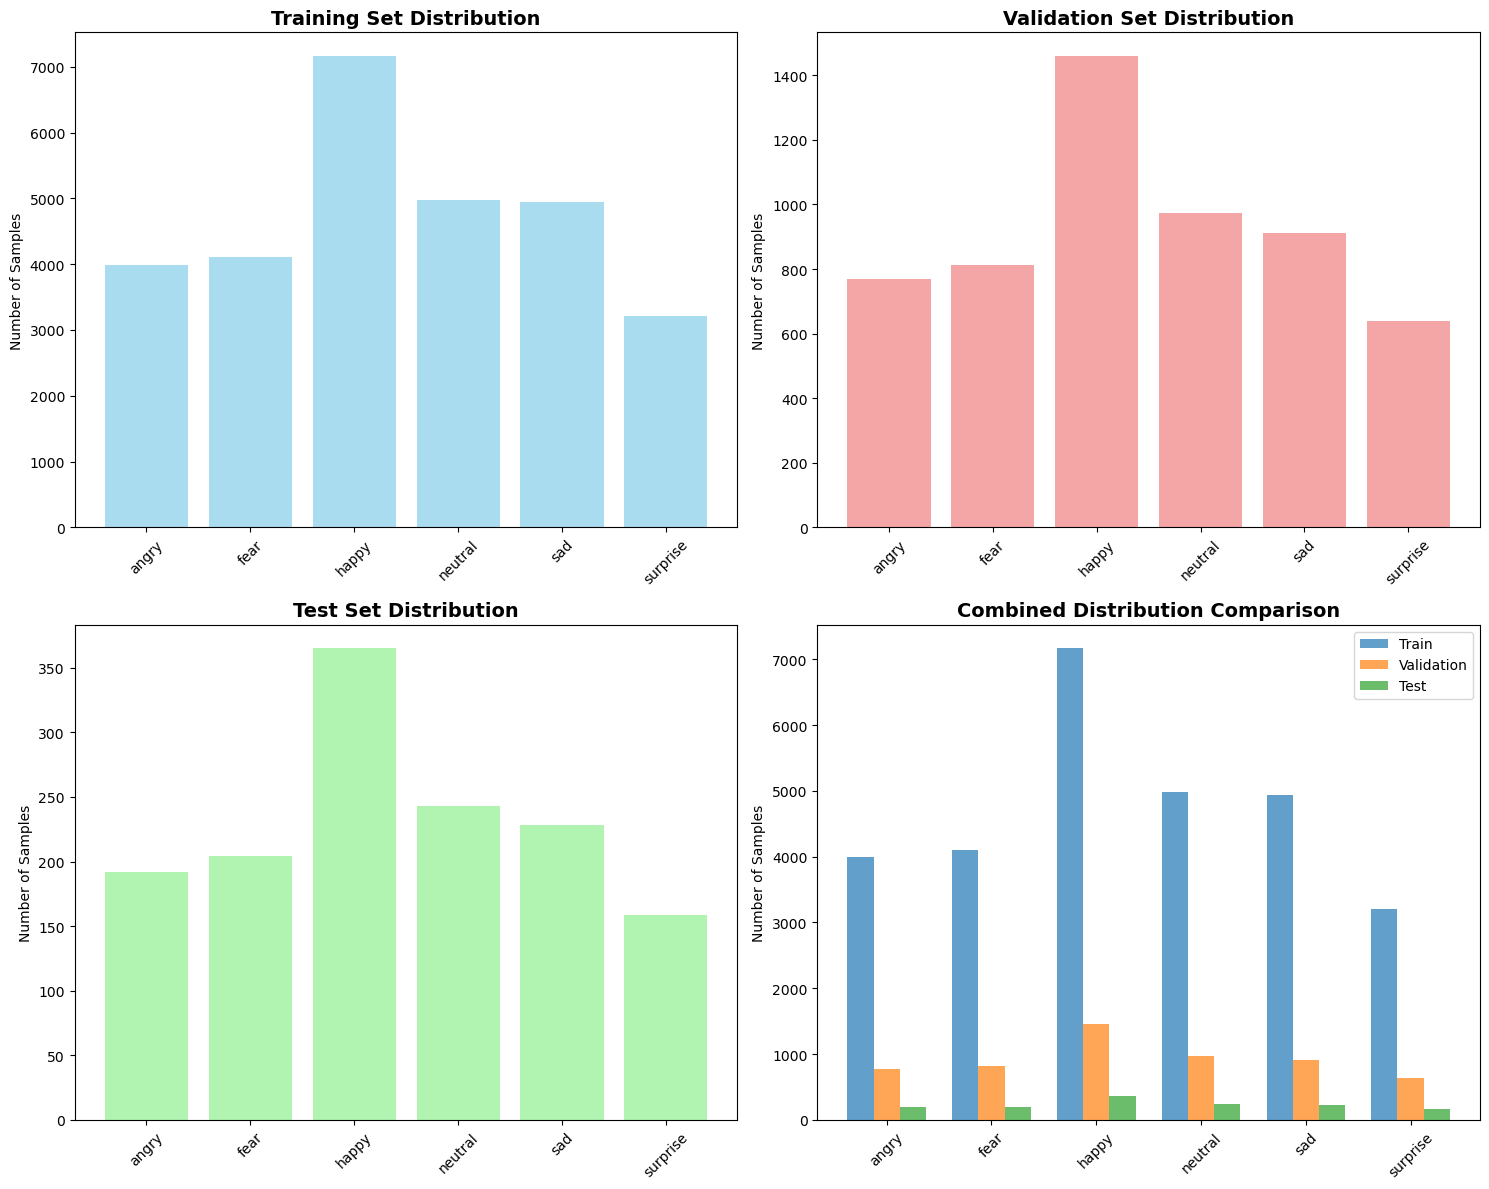

In [15]:
def plot_class_distributions(train_counts, val_counts, test_counts):
    """Create visualization of class distributions across all splits"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    emotions = list(train_counts.index)
    
    # Train distribution
    axes[0, 0].bar(emotions, train_counts.values, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Training Set Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Number of Samples')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Validation distribution  
    axes[0, 1].bar(emotions, val_counts.values, color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Validation Set Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Number of Samples')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Test distribution
    axes[1, 0].bar(emotions, test_counts.values, color='lightgreen', alpha=0.7)
    axes[1, 0].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Samples')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Combined view
    x_pos = np.arange(len(emotions))
    width = 0.25
    
    axes[1, 1].bar(x_pos - width, train_counts.values, width, label='Train', alpha=0.7)
    axes[1, 1].bar(x_pos, val_counts.values, width, label='Validation', alpha=0.7)
    axes[1, 1].bar(x_pos + width, test_counts.values, width, label='Test', alpha=0.7)
    axes[1, 1].set_title('Combined Distribution Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Samples')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(emotions, rotation=45)
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Create visualizations
plot_class_distributions(train_counts, val_counts, test_counts)

In [16]:
def calculate_balance_strategy(class_counts, strategy='moderate'):
    """Calculate target sample sizes for balancing"""
    total_samples = class_counts.sum()
    num_classes = len(class_counts)
    
    if strategy == 'uniform':
        # Make all classes equal to the smallest class
        target_size = class_counts.min()
    elif strategy == 'moderate':
        # Use a target size that reduces extreme imbalance but preserves some variation
        # Target: between min and mean
        target_size = int((class_counts.min() + class_counts.mean()) / 2)
    elif strategy == 'conservative':
        # Use mean as target - gentle balancing
        target_size = int(class_counts.mean())
    else:
        raise ValueError(f"Unknown strategy: {strategy}")
    
    print(f"\nBALANCING STRATEGY: {strategy.upper()}")
    print("=" * 50)
    print(f"Original total samples: {total_samples}")
    print(f"Target samples per class: {target_size}")
    print(f"New total samples: {target_size * num_classes}")
    print(f"Sample reduction: {total_samples - (target_size * num_classes)} ({((total_samples - (target_size * num_classes)) / total_samples * 100):.1f}%)")
    
    return target_size

# Calculate target sizes for different strategies
print("EVALUATING BALANCING STRATEGIES:")
print("=" * 60)

strategies = ['uniform', 'moderate', 'conservative']
targets = {}

for strategy in strategies:
    targets[strategy] = calculate_balance_strategy(train_counts, strategy)

# Choose moderate strategy as default
chosen_strategy = 'moderate'
target_samples_per_class = targets[chosen_strategy]

print(f"\n✓ CHOSEN STRATEGY: {chosen_strategy.upper()}")
print(f"✓ Target samples per class: {target_samples_per_class}")

EVALUATING BALANCING STRATEGIES:

BALANCING STRATEGY: UNIFORM
Original total samples: 28385
Target samples per class: 3205
New total samples: 19230
Sample reduction: 9155 (32.3%)

BALANCING STRATEGY: MODERATE
Original total samples: 28385
Target samples per class: 3967
New total samples: 23802
Sample reduction: 4583 (16.1%)

BALANCING STRATEGY: CONSERVATIVE
Original total samples: 28385
Target samples per class: 4730
New total samples: 28380
Sample reduction: 5 (0.0%)

✓ CHOSEN STRATEGY: MODERATE
✓ Target samples per class: 3967


In [17]:
def balance_dataset(df, target_size, random_state=42):
    """Balance dataset using undersampling/oversampling"""
    balanced_dfs = []
    
    print(f"\nBalancing dataset to {target_size} samples per class...")
    
    for emotion in df['label'].unique():
        emotion_df = df[df['label'] == emotion].copy()
        current_size = len(emotion_df)
        
        if current_size > target_size:
            # Undersample
            balanced_emotion_df = resample(
                emotion_df, 
                replace=False, 
                n_samples=target_size, 
                random_state=random_state
            )
            action = f"Undersampled from {current_size} to {target_size}"
        elif current_size < target_size:
            # Oversample
            balanced_emotion_df = resample(
                emotion_df, 
                replace=True, 
                n_samples=target_size, 
                random_state=random_state
            )
            action = f"Oversampled from {current_size} to {target_size}"
        else:
            # No change needed
            balanced_emotion_df = emotion_df
            action = f"No change needed ({current_size} samples)"
        
        print(f"  {emotion:10s}: {action}")
        balanced_dfs.append(balanced_emotion_df)
    
    # Combine all balanced classes
    balanced_df = pd.concat(balanced_dfs, ignore_index=True)
    
    # Shuffle the dataset
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return balanced_df

# Balance the training set (main focus)
print("BALANCING TRAINING SET:")
print("=" * 50)
balanced_train_df = balance_dataset(train_df, target_samples_per_class)

# For validation and test sets, use proportional balancing to maintain their relative sizes
val_target = int(target_samples_per_class * 0.2)  # ~20% of train size
test_target = int(target_samples_per_class * 0.05)  # ~5% of train size

print("\nBALANCING VALIDATION SET:")
print("=" * 50)
balanced_val_df = balance_dataset(val_df, val_target)

print("\nBALANCING TEST SET:")
print("=" * 50)
balanced_test_df = balance_dataset(test_df, test_target)

print("\n✓ Dataset balancing completed!")

BALANCING TRAINING SET:

Balancing dataset to 3967 samples per class...
  angry     : Undersampled from 3993 to 3967
  fear      : Undersampled from 4103 to 3967
  happy     : Undersampled from 7164 to 3967
  neutral   : Undersampled from 4982 to 3967
  sad       : Undersampled from 4938 to 3967
  surprise  : Oversampled from 3205 to 3967

BALANCING VALIDATION SET:

Balancing dataset to 793 samples per class...
  angry     : Oversampled from 768 to 793
  fear      : Undersampled from 814 to 793
  happy     : Undersampled from 1460 to 793
  neutral   : Undersampled from 973 to 793
  sad       : Undersampled from 911 to 793
  surprise  : Oversampled from 638 to 793

BALANCING TEST SET:

Balancing dataset to 198 samples per class...
  angry     : Oversampled from 192 to 198
  fear      : Undersampled from 204 to 198
  happy     : Undersampled from 365 to 198
  neutral   : Undersampled from 243 to 198
  sad       : Undersampled from 228 to 198
  surprise  : Oversampled from 159 to 198

✓ D

VERIFYING BALANCED DISTRIBUTIONS:

BALANCED TRAIN SET CLASS DISTRIBUTION:
angry     :  3967 (16.67%) - BALANCED
fear      :  3967 (16.67%) - BALANCED
happy     :  3967 (16.67%) - BALANCED
neutral   :  3967 (16.67%) - BALANCED
sad       :  3967 (16.67%) - BALANCED
surprise  :  3967 (16.67%) - BALANCED

Total samples: 23802
Mean per class: 3967.0
Std deviation: 0.0
Balance ratio (min/max): 1.000

BALANCED VALIDATION SET CLASS DISTRIBUTION:
angry     :   793 (16.67%) - BALANCED
fear      :   793 (16.67%) - BALANCED
happy     :   793 (16.67%) - BALANCED
neutral   :   793 (16.67%) - BALANCED
sad       :   793 (16.67%) - BALANCED
surprise  :   793 (16.67%) - BALANCED

Total samples: 4758
Mean per class: 793.0
Std deviation: 0.0
Balance ratio (min/max): 1.000

BALANCED TEST SET CLASS DISTRIBUTION:
angry     :   198 (16.67%) - BALANCED
fear      :   198 (16.67%) - BALANCED
happy     :   198 (16.67%) - BALANCED
neutral   :   198 (16.67%) - BALANCED
sad       :   198 (16.67%) - BALANCED
surprise

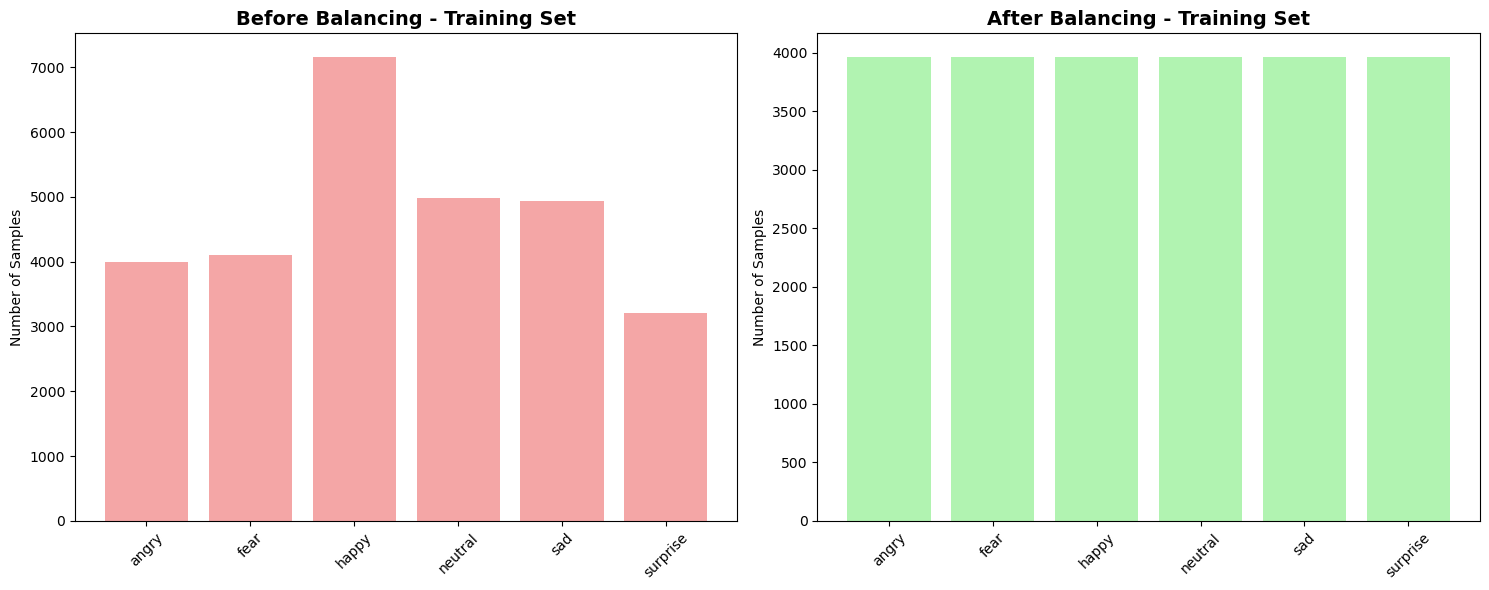

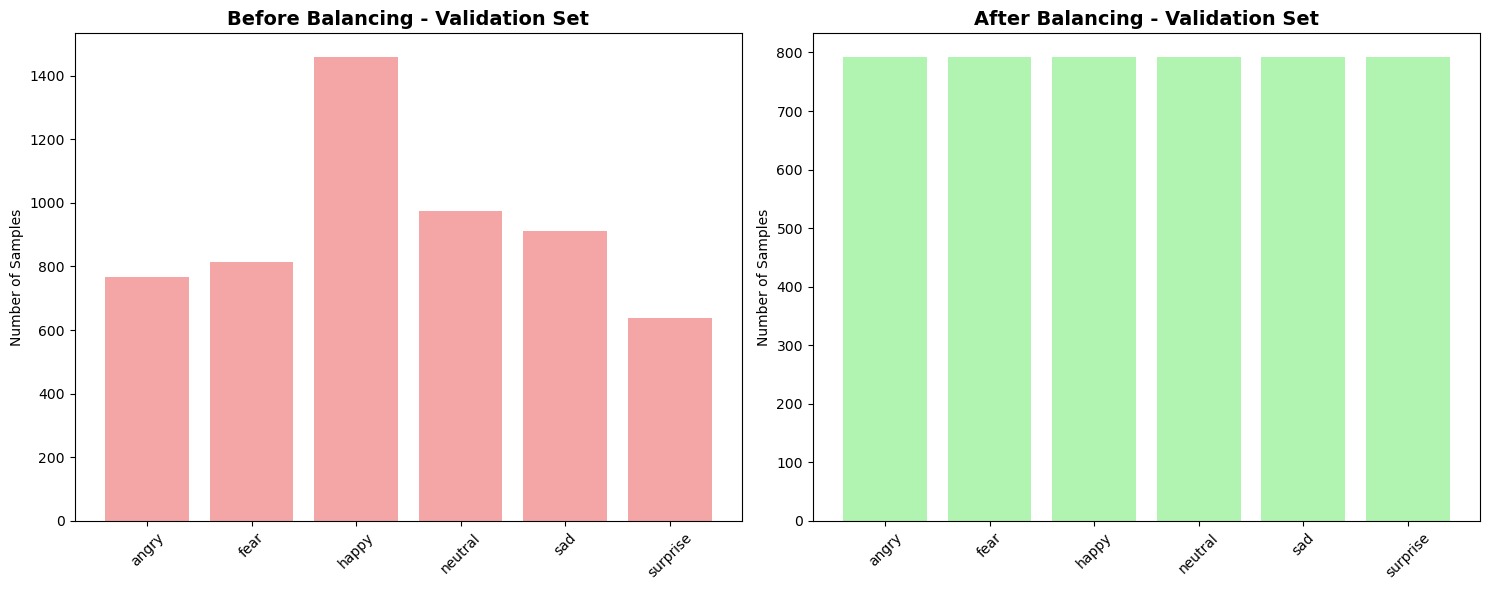

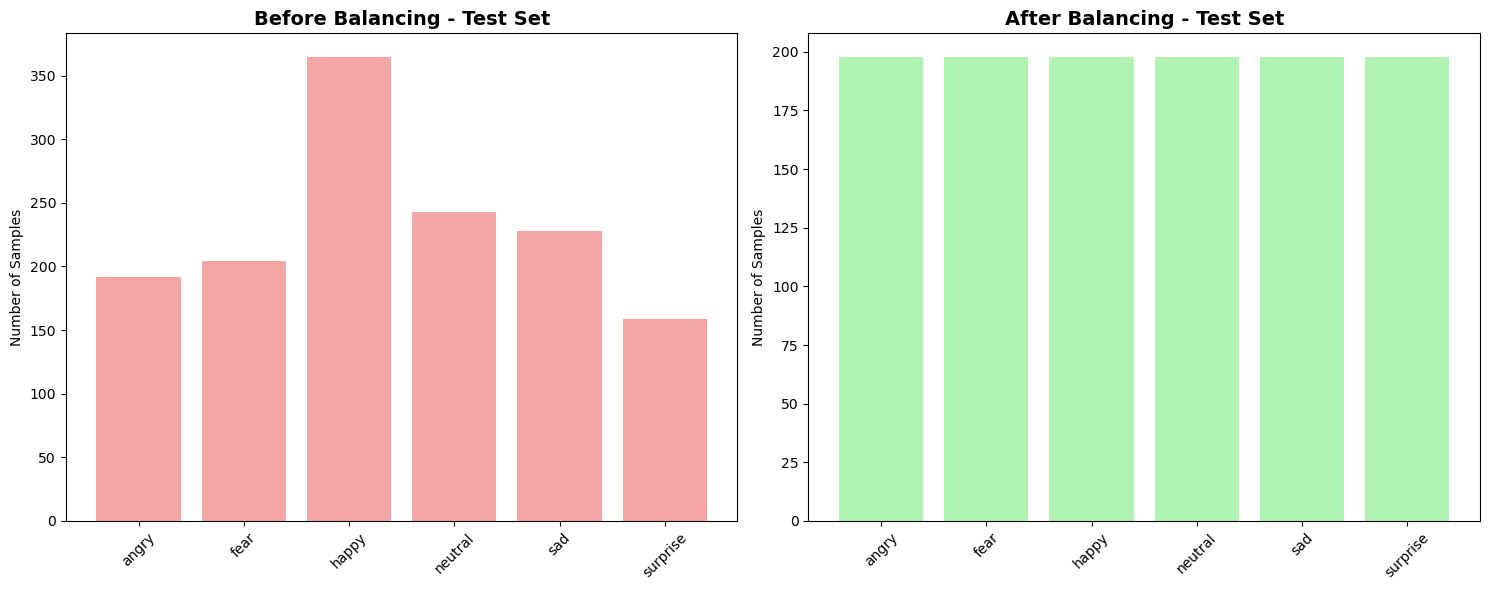

In [18]:
# Verify the balanced distributions
print("VERIFYING BALANCED DISTRIBUTIONS:")
print("=" * 60)

balanced_train_counts, _ = analyze_class_distribution(balanced_train_df, "balanced train")
balanced_val_counts, _ = analyze_class_distribution(balanced_val_df, "balanced validation")
balanced_test_counts, _ = analyze_class_distribution(balanced_test_df, "balanced test")

# Create comparison visualization
def plot_before_after_comparison(original_counts, balanced_counts, split_name):
    """Plot before and after comparison"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    emotions = list(original_counts.index)
    
    # Before
    ax1.bar(emotions, original_counts.values, color='lightcoral', alpha=0.7)
    ax1.set_title(f'Before Balancing - {split_name}', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)
    
    # After
    ax2.bar(emotions, balanced_counts.values, color='lightgreen', alpha=0.7)
    ax2.set_title(f'After Balancing - {split_name}', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Samples')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Create before/after visualizations
plot_before_after_comparison(train_counts, balanced_train_counts, "Training Set")
plot_before_after_comparison(val_counts, balanced_val_counts, "Validation Set")
plot_before_after_comparison(test_counts, balanced_test_counts, "Test Set")

In [19]:
# Save balanced datasets
print("SAVING BALANCED DATASETS:")
print("=" * 50)

# Create output directory if it doesn't exist
output_dir = PROJECT_ROOT / 'data/processed/EmoSet_splits'
output_dir.mkdir(parents=True, exist_ok=True)

# Save CSV files
balanced_train_df.to_csv(CSV_TRAIN, index=False)
balanced_val_df.to_csv(CSV_VAL, index=False)
balanced_test_df.to_csv(CSV_TEST, index=False)

# Also save with "_balanced" suffix for backup
balanced_train_df.to_csv(BALANCED_TRAIN_CSV, index=False)
balanced_val_df.to_csv(BALANCED_VAL_CSV, index=False)
balanced_test_df.to_csv(BALANCED_TEST_CSV, index=False)

print(f"✓ Saved: {CSV_TRAIN}")
print(f"✓ Saved: {CSV_VAL}")
print(f"✓ Saved: {CSV_TEST}")
print(f"✓ Backup saved: {BALANCED_TRAIN_CSV}")
print(f"✓ Backup saved: {BALANCED_VAL_CSV}")
print(f"✓ Backup saved: {BALANCED_TEST_CSV}")

# Update statistics
balanced_stats = {
    "dataset": "EmoSet_Balanced",
    "balancing_strategy": chosen_strategy,
    "target_samples_per_class": {
        "train": target_samples_per_class,
        "val": val_target,
        "test": test_target
    },
    "splits": {
        "train": {
            "total": len(balanced_train_df),
            "by_label": balanced_train_counts.to_dict()
        },
        "val": {
            "total": len(balanced_val_df),
            "by_label": balanced_val_counts.to_dict()
        },
        "test": {
            "total": len(balanced_test_df),
            "by_label": balanced_test_counts.to_dict()
        }
    },
    "balance_metrics": {
        "train_balance_ratio": float(balanced_train_counts.min() / balanced_train_counts.max()),
        "val_balance_ratio": float(balanced_val_counts.min() / balanced_val_counts.max()),
        "test_balance_ratio": float(balanced_test_counts.min() / balanced_test_counts.max())
    }
}

# Save updated stats
with open(STATS_PATH, 'w') as f:
    json.dump(balanced_stats, f, indent=2)

with open(BALANCED_STATS_PATH, 'w') as f:
    json.dump(balanced_stats, f, indent=2)

print(f"✓ Saved: {STATS_PATH}")
print(f"✓ Backup saved: {BALANCED_STATS_PATH}")

print("\n✅ DATASET BALANCING COMPLETED SUCCESSFULLY!")
print("=" * 60)
print(f"📊 Balanced training samples: {len(balanced_train_df)}")
print(f"📊 Balanced validation samples: {len(balanced_val_df)}")
print(f"📊 Balanced test samples: {len(balanced_test_df)}")
print(f"📊 Balance ratio (train): {balanced_train_counts.min() / balanced_train_counts.max():.3f}")
print(f"📊 Samples per class (train): {target_samples_per_class}")

SAVING BALANCED DATASETS:
✓ Saved: ../data/processed/EmoSet_splits/train.csv
✓ Saved: ../data/processed/EmoSet_splits/val.csv
✓ Saved: ../data/processed/EmoSet_splits/test.csv
✓ Backup saved: ../data/processed/EmoSet_splits/train_balanced.csv
✓ Backup saved: ../data/processed/EmoSet_splits/val_balanced.csv
✓ Backup saved: ../data/processed/EmoSet_splits/test_balanced.csv
✓ Saved: ../data/processed/EmoSet_splits/stats.json
✓ Backup saved: ../data/processed/EmoSet_splits/stats_balanced.json

✅ DATASET BALANCING COMPLETED SUCCESSFULLY!
📊 Balanced training samples: 23802
📊 Balanced validation samples: 4758
📊 Balanced test samples: 1188
📊 Balance ratio (train): 1.000
📊 Samples per class (train): 3967


In [20]:
# Final summary and recommendations
print("📋 DATASET BALANCING SUMMARY")
print("=" * 60)

print("\n🔍 BEFORE BALANCING:")
print(f"  • Most frequent class: happy ({train_counts['happy']} samples, {train_pct['happy']:.1f}%)")
print(f"  • Least frequent class: surprise ({train_counts['surprise']} samples, {train_pct['surprise']:.1f}%)")
print(f"  • Balance ratio: {train_counts.min() / train_counts.max():.3f}")

print("\n✅ AFTER BALANCING:")
print(f"  • All classes: {target_samples_per_class} samples each ({100/len(label_map):.1f}%)")
print(f"  • Balance ratio: {balanced_train_counts.min() / balanced_train_counts.max():.3f}")
print(f"  • Total reduction: {len(train_df) - len(balanced_train_df)} samples")

print("\n🎯 EXPECTED BENEFITS:")
print("  • Reduced bias towards 'happy' emotion")
print("  • Improved recognition of 'surprise' and 'angry' emotions")
print("  • More balanced confusion matrix")
print("  • Better overall classification performance")

print("\n📁 OUTPUT FILES:")
print(f"  • {CSV_TRAIN.name} - Balanced training set")
print(f"  • {CSV_VAL.name} - Balanced validation set")
print(f"  • {CSV_TEST.name} - Balanced test set")
print(f"  • {LABEL_MAP_PATH.name} - Label mapping (unchanged)")
print(f"  • {STATS_PATH.name} - Updated statistics")

print("\n🚀 NEXT STEPS:")
print("  1. Run updated 01_eda.ipynb to verify balanced distributions")
print("  2. Train CNN model using balanced datasets")
print("  3. Compare performance metrics with original imbalanced model")
print("  4. Monitor per-class accuracy improvements")

print("\n✅ Feature engineering and dataset balancing completed successfully!")

📋 DATASET BALANCING SUMMARY

🔍 BEFORE BALANCING:
  • Most frequent class: happy (7164 samples, 25.2%)
  • Least frequent class: surprise (3205 samples, 11.3%)
  • Balance ratio: 0.447

✅ AFTER BALANCING:
  • All classes: 3967 samples each (16.7%)
  • Balance ratio: 1.000
  • Total reduction: 4583 samples

🎯 EXPECTED BENEFITS:
  • Reduced bias towards 'happy' emotion
  • Improved recognition of 'surprise' and 'angry' emotions
  • More balanced confusion matrix
  • Better overall classification performance

📁 OUTPUT FILES:
  • train.csv - Balanced training set
  • val.csv - Balanced validation set
  • test.csv - Balanced test set
  • label_map.json - Label mapping (unchanged)
  • stats.json - Updated statistics

🚀 NEXT STEPS:
  1. Run updated 01_eda.ipynb to verify balanced distributions
  2. Train CNN model using balanced datasets
  3. Compare performance metrics with original imbalanced model
  4. Monitor per-class accuracy improvements

✅ Feature engineering and dataset balancing comp